## Gaussian mixture models with PyMC3

This is a PyMC3 implementation of the example in [Latent variable models - part 1: Gaussian mixture models and the EM algorithm](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/latent-variable-models/latent_variable_models_part_1.ipynb). In contrast to the linked article, model parameters are inferred using a Bayesian approach insetad of maximum likelihood. The following code is mainly inspired by [this notebook](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/master/WIP/%5BWIP%5D%20Bayesian%20GMM.ipynb).

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import warnings

from latent_variable_models_util import n_true, mu_true, sigma_true
from latent_variable_models_util import generate_data, plot_data, plot_densities

warnings.filterwarnings('ignore')

%matplotlib inline

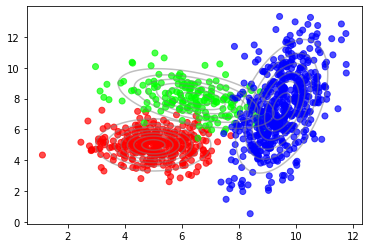

In [2]:
X, T = generate_data(n=n_true, mu=mu_true, sigma=sigma_true)
C = T.shape[1]

plot_data(X, color=T)
plot_densities(X, mu=mu_true, sigma=sigma_true)

## Model

Here, we use a [marginalized Gaussian mixture model](https://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html)  where latent variables $\mathbf{t}_i$ are marginalized out. Marginalized mixture models can be readily implemented with the [`Mixture`](https://docs.pymc.io/api/distributions/mixture.html#pymc3.distributions.mixture.Mixture) class of PyMC3. Marginalizing out latent variables leads to more efficient MCMC sampling compared to additionally [sampling discrete latent variables](https://docs.pymc.io/notebooks/gaussian_mixture_model.html). 

Mixture components are modeled as multivariate normal distributions. For modeling the uncertainty in component weights a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) prior is used, for component means a multivariate normal prior. For modeling the uncertainty in covariance matrices, the LKJ distribution is used.

### LKJ distribution

The conjugate prior for the covariance matrix $\mathbf\Sigma$ of a multivariate normal distribution is the [inverse Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution). Related, the conjugate prior for the precision matrix $\mathbf\Lambda = \mathbf\Sigma^{-1}$ is the [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution). For Bayesian computational methods, these distributions are [not well-suited](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94153586) for modeling the uncertainty in covariance and precision matrices, respectively, and usage of the [Lewandowski-Kurowicka-Joe (LKJ) prior](https://www.sciencedirect.com/science/article/pii/S0047259X09000876) is preferred in this context.

The LKJ distribution provides a prior on the [correlation matrix](https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices) $\mathrm{C}$. Combined with the standard deviations of each component, this induces a prior on the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) $\mathbf\Sigma$. For better numerical stability, the LKJ distribution is often used as prior for the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of the covariance matrix $\mathbf\Sigma = \mathbf{L}\mathbf{L}^T$ where $\mathbf{L}$ is a lower-triangular matrix. PyMC3 implements this distribution via [`LKJCholeskyCov`](https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.LKJCholeskyCov). For further details see PyMC3's [LKJ documentation](https://docs.pymc.io/notebooks/LKJ.html).

In [3]:
with pm.Model() as model:
    # Prior on components weights
    w = pm.Dirichlet('w', np.ones(C))
    
    # Mixture components (multivariate normal distributions)
    components = []
    
    for i in range(C):
        # Prior on component mean
        mu = pm.Normal(f'mu{i}', mu=0, sigma=10, shape=2)        
        
        # Prior on Cholesky factor L of component covariance matrix
        L_packed = pm.LKJCholeskyCov(f'L{i}', eta=2.0, n=2, sd_dist=pm.HalfNormal.dist(sigma=10))
        L = pm.expand_packed_triangular(2, L_packed, lower=True)
        
        # Component multivariate normal can be parameterized 
        # directly with Cholesky factor L of covariance matrix 
        components.append(pm.MvNormal.dist(mu=mu, chol=L))
        
    # Mixture distribution
    x_obs = pm.Mixture('x_obs', w=w, comp_dists=components, observed=X)

## Inference

We can use the model definition above for both, MCMC inference and variational inference. For MCMC sampling, only a single chain is used to avoid the [label switching](https://discourse.pymc.io/t/properly-sampling-mixture-models/986) problem. Different chains may assign different labels (`0`, `1`, ..., `C-1`) to the same component which makes computation of statistics across different chains impossible. For 1D distributions, label switching can be avoided by adding further constraints to the model but this is not possible any more with higher-dimensional distributions, hence, only a single chain is used in which label switching usually does not occur. The downside of using a single chain is that it prevents convergence checks.

In [4]:
# True for MCMC inference, False for variational inference with ADVI.
use_MCMC = True

if use_MCMC:
    with model:
        trace = pm.sample(chains=1)
else:
    with model:
        approx = pm.fit(n=70000, method='advi')

    # Sample from variational approximation
    trace = approx.sample(1000)
    
    plt.plot(approx.hist)
    plt.ylim(3000, 8000)        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [L2, mu2, L1, mu1, L0, mu0, w]
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [01:27<00:00, 11.41it/s]
The acceptance probability does not match the target. It is 0.990836116032205, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Results

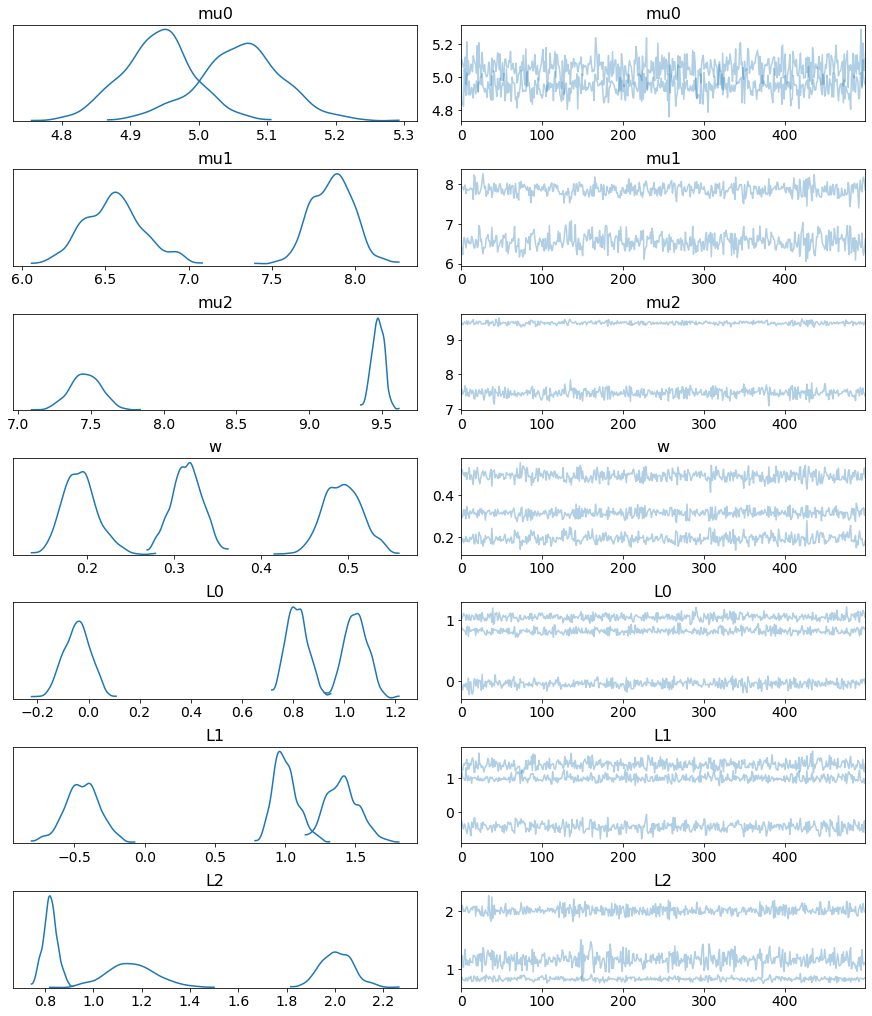

In [5]:
pm.traceplot(trace);

### Compute component statistics from samples

The following obtains point estimates of component means and covariance matrices from traces and compares them with the true means and covariance matrices that have been used to generate the example data. Uncertainties are **not** computed and visualized here.

In [6]:
def estimate_mu(mu_samples):
    return np.mean(mu_samples, axis=0)

def estimate_cov(chol_samples):
    L = pm.expand_packed_triangular(2, np.mean(chol_samples, axis=0)).eval()
    return L.dot(L.T)

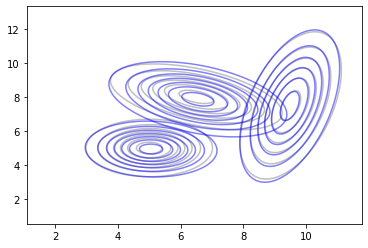

In [7]:
mu_hat = [estimate_mu(trace[f'mu{i}']) for i in range(C)]
cov_hat = [estimate_cov(trace[f'L{i}']) for i in range(C)]

# Plot true densities
plot_densities(X, mu=mu_true, sigma=sigma_true, colors='grey')

# Plot inferred densities (point estimate)
plot_densities(X, mu=mu_hat, sigma=cov_hat, colors='blue')

### Log probabilities of data


To compute per-component log probabilities of example data `X`, we first set model parameters to their point estimates (as done in the previous section) using a data structure obtained with `model.test_point`.

In [8]:
point = model.test_point
point

{'w_stickbreaking__': array([0., 0.]),
 'mu0': array([0., 0.]),
 'L0_cholesky-cov-packed__': array([0., 0., 0.]),
 'mu1': array([0., 0.]),
 'L1_cholesky-cov-packed__': array([0., 0., 0.]),
 'mu2': array([0., 0.]),
 'L2_cholesky-cov-packed__': array([0., 0., 0.])}

In [9]:
for i in range(C):
    mu_name = f'mu{i}'
    ccov_name = f'L{i}_cholesky-cov-packed__'
    point[mu_name] = np.mean(trace[mu_name], axis=0)
    point[ccov_name] = np.mean(trace[ccov_name], axis=0)    

point

{'w_stickbreaking__': array([0., 0.]),
 'mu0': array([5.06076299, 4.93871737]),
 'L0_cholesky-cov-packed__': array([ 0.04412761, -0.04580195, -0.20473121]),
 'mu1': array([6.54963946, 7.85957068]),
 'L1_cholesky-cov-packed__': array([ 0.34149407, -0.44524205,  0.00119757]),
 'mu2': array([9.47593602, 7.46077441]),
 'L2_cholesky-cov-packed__': array([-0.19615233,  1.15722983,  0.6967298 ])}

Then we use the updated data structure to compute per-component log probabilities `t` using a trick that I found in [this notebook](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/master/WIP/%5BWIP%5D%20Bayesian%20GMM.ipynb):

In [10]:
from theano import shared

comp_logp = x_obs.distribution._comp_logp(shared(X))
comp_logp_f = model.model.fastfn(comp_logp)

t = comp_logp_f(point)
t

array([[ -1.86319916,  -6.75509066, -17.90297198],
       [ -2.93381889,  -6.06466349, -25.17770424],
       [ -2.2629196 ,  -9.59037877, -28.40775583],
       ...,
       [-24.2285852 ,  -6.48557589,  -2.61799319],
       [ -7.56633026,  -4.64306777,  -3.05450728],
       [-17.16583352,  -4.92669935,  -2.41548278]])

These log probabilities can be used to visualize the soft-assignment of example data to components.

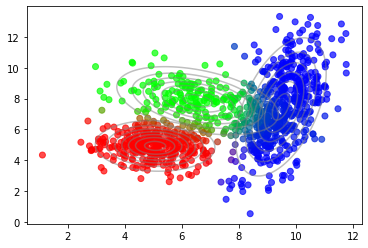

In [11]:
t_norm = np.exp(t) / np.sum(np.exp(t), axis=1, keepdims=True)

plot_data(X, color=t_norm)
plot_densities(X, mu=mu_hat, sigma=cov_hat)